# Timeseries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

We will use the AirPassengers dataset this time: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/AirPassengers.csv 

Load it as a dataframe in _df_ variable and show first 5 rows. 

Ignore the first rowid column.

In [2]:
df = 
df.head()

,time,AirPassengers
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


## Creating a Timeseries object

Show the column types of _df_.

time             float64
AirPassengers      int64
dtype: object

The _time_ field signifies the year and a 1/12th fraction (the month). We need to convert this to a datetime type. Write a function that converts the time-column into a [_datetime_](https://docs.python.org/2/library/datetime.html#datetime-objects) object.

In [4]:
def to_datetime(number):
    return(datetime(...))

to_datetime(1949.166667)

datetime.datetime(1949, 3, 1, 0, 0)

Make a Pandas [_Series_](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html#pandas-series) object named _ts_ with _AirPassangers_ number as data and _datetime_ as index.

In [5]:
ts = pd.Series(...)

In [6]:
ts.head()

time
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

Lets see how slicing works. Select a range [1949-01-01, 1949-12-01]. There are many ways to do this. For some, the index needs to be sorted.

time
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
dtype: int64

## Exploration

Make a plot of the timeseries.

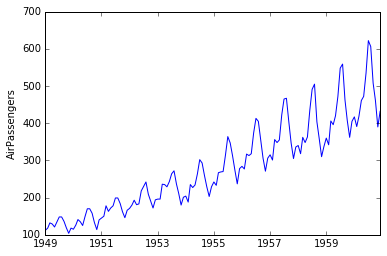

In [8]:
plt.plot(...);
plt.ylabel('AirPassengers');

### Variance stabilization

The plot makes it clear that the variance is not constant with time. Cosntant variance is a requirement for good forecasts with many models, certainly ARIMA which is based on Linear Regression. One way of dealing with this is taking the log of the original data. Modeling _tslog_ will bascially model _ts_ elasticity (i.e. percentual changes).

Take the log, store it in _tslog_ variable and plot it.

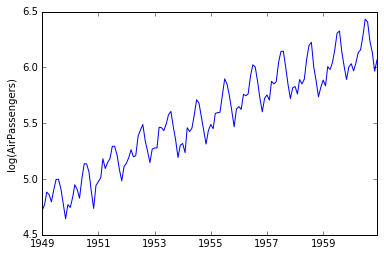

The variance seems stable now.

### Trend: deterministic or stochastic

In [10]:
from statsmodels.tsa.stattools import adfuller

W:\Tools\conda\program\x64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


There is clearly a trend in the series. For forecasting, it is important to know whether this trend is deterministic or stochastic. A deterministic trend is of the form $Y_t = \beta_0 + \beta_1 t + \mu_t$ whereas a stochastic trend is of the form $Y_t = Y_{t-1} + \mu_t$ (i.e. a random walk). The latter can be written as $Y_t = Y_0 + \sum_{i=0}^t \mu_i$ and thus the trend $\sum_{i=0}^t \mu_i$ is called stochastic. Random walk has an "infinite memory" in the sense that random shocks are persistent in the sum. This makes forecasting difficult. If we write  $Y_t = \rho Y_{t-1} + \mu_t$ with $|\rho| < 1$, then we know that the shock will eventually die out and the series is stationary. The [Augmented-Dickey Fuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) (ADF) test is one of the Unit Root statistical tests that tests whether $\rho = 1$. 

The null hypothesis of ADF test is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root.

Run the ADF test under the assumption that the $\mu_t$ are uncorrelated (i.e. maxlag = 1). This is equivalent to the (non-augmented) DF test. Also, make sure to use linear regression (set regression='ct'): we want to check for a stochastic trend under the assumption of a deterministic trend.

In [11]:
adf_test = 
adf_test

(-7.6522870043113969,
 4.5434210719523852e-10,
 {'1%': -4.0239809181472488,
  '10%': -3.1454609207316904,
  '5%': -3.4418722820477714},
 <statsmodels.tsa.stattools.ResultsStore at 0x242fc4520b8>)

We get $p \ll 0.01$ (second variable) which means we can reject $H_0: \rho = 1$. In other words, there is significant evidence that $\rho < 1$ (i.e. that the trend is deterministic). In other words the forecasts from classical models will not be biased.

Note that ADF, when using lags, is susceptible to seasonality effects.

### Seasonality

The seasonality can be obtained from autocorrelation plots. Since the trend is deterministic, the residuals of $Y_t = \beta_0 + \beta_1 t + \mu_t$ are stationary. In case it was a unit root, then first-order differentiating the timeseries would make the series stationary.

Extract the residuals from $Y_t = \beta_0 + \beta_1 t + \mu_t$ and place them in _tslogdet_. This procedure is called detrending. A quick way is to use [scipy.signal.detrend](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.detrend.html). You can also use sklearn.linear_model. The results are the same.

In [12]:
from scipy.signal import detrend
tslogdet = 

Plot _tslogdet_.

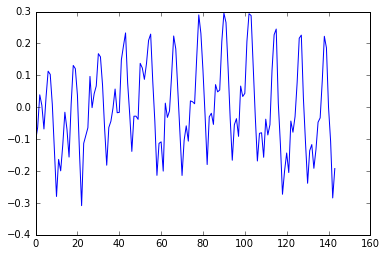

Make an autocorrelation plot of _tslog_ and _tslogdet_.

In [14]:
from pandas.plotting import autocorrelation_plot

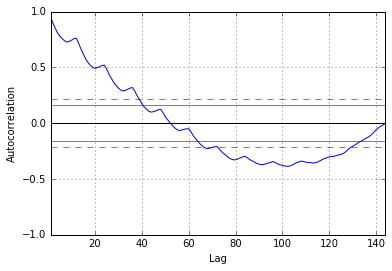

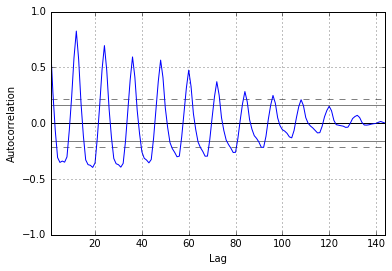

In [15]:
...
plt.show()
...

The first autocorrelation plot clearly shows very high correlation with previous values, which suggests non-stationarity, and which is removed with detrending in our case (or differentiation in unit root case). The latter plot show correlation spikes due to seasonality. One can zoom-in and see that the spikes are at lag 12: season is yearly in this case.

# ARIMA(X)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import brute

In previous analysis we learned a few things about the nature of the series. We can now use that information to construct an ARIMAX model for forecasting. Use the [Nedler-Mead](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) for minimization. The default has convergence issues.

In [17]:
def arima_select(order):
    if all(order == 0): return(float("inf"))
    try:
        m_ar = SARIMAX(tslog, trend='ct', order=order.tolist()[:3], 
                       seasonal_order=order.tolist()[3:], 
                       enforce_stationarity=False, 
                       enforce_invertibility=False
                      ).fit(maxiter=5000, method='nm')
        bic = m_ar.bic
    except:
        return(float("inf"))
    print((order, bic))
    return(float("inf") if np.isnan(bic) else bic)

SARIMAX needs a few parameters. The seasonality (_s_) we estimated to be 12 from previous graphs. Then there is the choice of either adding a trend line and/or differentiate the series (_d_ and _D_). Snice we already checked the trend to be  only deterministic, we set _d_ = _D_ = 0 and use trend = 'ct' as the modeling option. Then we still have to estimate the Autoregressive (_p_ and _P_) and Moving average (_q_ and _Q_) components. We set their range to [0,2] and select the best model based on the BIC scores.

In [18]:
grid = (slice(0, 3), slice(0, 1), slice(0, 3), # (p,d,q)
        slice(0, 3), slice(0, 1), slice(0, 3), slice(12,13))  # (P,D,Q,s)
brute(arima_select, grid, finish=None)

Optimization terminated successfully.
         Current function value: -0.802184
         Iterations: 247
         Function evaluations: 421
(array([ 0,  0,  0,  0,  0,  1, 12]), -211.14967833604013)
Optimization terminated successfully.
         Current function value: -0.837790
         Iterations: 837
         Function evaluations: 1369
(array([ 0,  0,  0,  0,  0,  2, 12]), -216.43457328265259)
Optimization terminated successfully.
         Current function value: -1.300289
         Iterations: 239
         Function evaluations: 411
(array([ 0,  0,  0,  1,  0,  0, 12]), -354.6038861345225)
Optimization terminated successfully.
         Current function value: -1.433900
         Iterations: 349
         Function evaluations: 582
(array([ 0,  0,  0,  1,  0,  1, 12]), -388.11409120247072)
Optimization terminated successfully.
         Current function value: -1.314378
         Iterations: 989
         Function evaluations: 1527
(array([ 0,  0,  0,  1,  0,  2, 12]), -348.72206652974404)

array([  1.,   0.,   0.,   1.,   0.,   1.,  12.])

Fit the best model and display its summary.

In [19]:
m_ar = 
print(m_ar.summary())

Optimization terminated successfully.
         Current function value: -1.701415
         Iterations: 503
         Function evaluations: 787
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                 245.004
Date:                            Fri, 05 Jan 2018   AIC                           -478.008
Time:                                    16:03:12   BIC                           -460.189
Sample:                                01-01-1949   HQIC                          -470.767
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

Plot the diagnostics. If the residuals are normaly distributed, then it means we found a good fit. The QQ-plot is a good indicator for this. Also, the seasonality should not be apparent in the residuals.

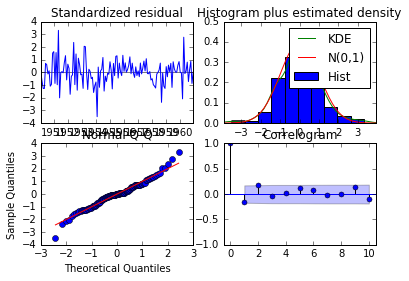

Get the predictions and confidence intervals. Start them from 1951-01-01 and forcast for some 4 years (1965-01-01).

In [21]:
pred = 

Plot the original timeseries, predictions and confidence intervals.

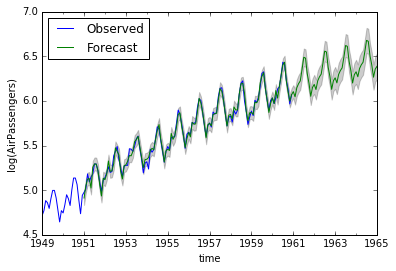

In [22]:
ax = tslog.plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax, label='Forecast')
ax.fill_between(pred.conf_int().index,
                pred.conf_int()['lower y'],
                pred.conf_int()['upper y'], color='k', alpha=.2)
plt.legend(loc = 'upper left');
plt.ylabel('log(AirPassengers)');

Now obviously you could do the seasonality/trend analysis the brute-force way, but that would take lots of computational time. Visual inspection of variance, seasonality and trend is mandatory for a good ARIMA model.

Too easy? Go [here](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).
For a background on the requirement of stationarity, impact of correlation, structural breaks and much more, a great book to start is Gujarati, D. e.a., _Basic Econometrics_, 2009. It also has chapters on multi-timeseries modeling and forecasting.

# Moving average

Moving average is a general term for a few "low-pass filter" models. More information can be found [here](https://en.wikipedia.org/wiki/Moving_average). Python offers a few smoothing functions in the form of [rolling window functions](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling), but these can not be used for forecasting.

## Simple moving average

## Exponential smoothing